In [1]:
!pip install keras-tcn


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tcn import TCN
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

def forecast_sentiment_with_tcn(df, aspect_name, seq_len=10, test_days=200, epochs=100):
    if 'positive_score' not in df.columns or 'negative_score' not in df.columns:
        sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        df['positive_score'] = df['aspect_sentiment'].map(lambda x: sentiment_map.get(x, 1))
        df['negative_score'] = 2 - df['positive_score']

    df['sentiment_index'] = df['positive_score'] - df['negative_score']
    df_aspect = df[df['predicted_aspects'].str.lower() == aspect_name.lower()].copy()
    df_aspect['date'] = pd.to_datetime(df_aspect['at']).dt.date
    df_aspect = df_aspect[['date', 'sentiment_index']].dropna().sort_values('date').reset_index(drop=True)

    df_aspect['sentiment_index'] = df_aspect['sentiment_index'].rolling(window=5, min_periods=1).mean()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_aspect[['sentiment_index']])
    series = pd.Series(scaled.flatten(), index=df_aspect.index)

    X, y = create_sequences(series.values, seq_len)
    X_train, X_test = X[:-test_days], X[-test_days:]
    y_train, y_test = y[:-test_days], y[-test_days:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential([
    TCN(nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8], return_sequences=True, dropout_rate=0.3),
    TCN(nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8]),
    Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mse')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32,
                        validation_data=(X_test, y_test), verbose=1)

    preds = model.predict(X_test)
    preds_inv = scaler.inverse_transform(preds)
    y_true_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 5))
    plt.plot(y_true_inv, label="Actual", color="red")
    plt.plot(preds_inv, label="Predicted", color="blue")
    plt.title(f"{aspect_name.capitalize()} Sentiment Forecast vs Actual (TCN)")
    plt.xlabel("Time Step")
    plt.ylabel("Sentiment Index")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label="Training Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_true_inv, preds_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_inv, preds_inv)
    r2 = r2_score(y_true_inv, preds_inv)
    print(f"\n📊 Evaluation for aspect: '{aspect_name}' using TCN")
    print(f"  MSE  : {mse:.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

In [4]:
df = pd.read_csv("/content/bert_extracted_with_sentiment_score.csv")


📈 Running TCN forecast for aspect: 'driver'


<ipython-input-3-d57d51fa901d>:30: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at']).dt.date


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 391ms/step - loss: 18.9350 - val_loss: 1.1088
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4669 - val_loss: 0.7172
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0251 - val_loss: 0.5906
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7776 - val_loss: 0.4699
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6949 - val_loss: 0.4095
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6731 - val_loss: 0.3617
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5405 - val_loss: 0.3163
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5239 - val_loss: 0.2993
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5137 - val_loss: 0.3038
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4131 - val_loss: 0.3081
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4118 - val_loss: 0.3071
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - l

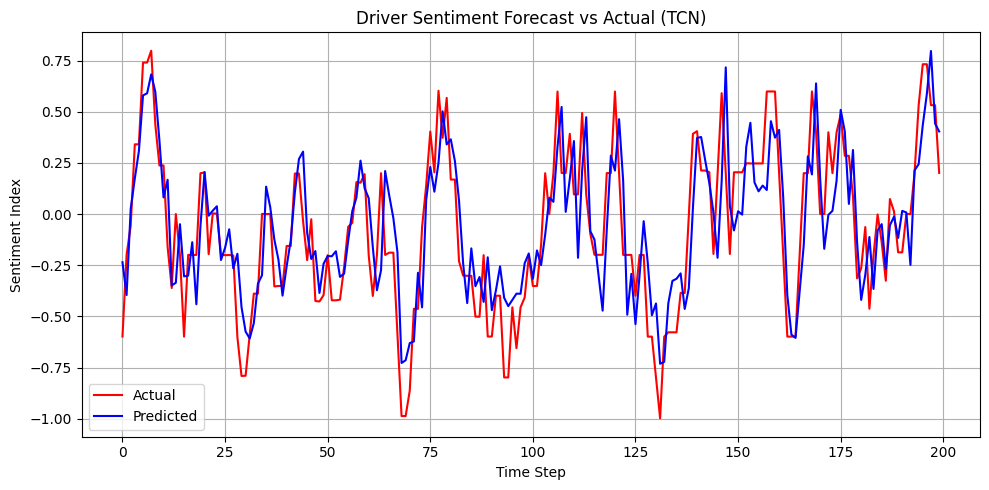

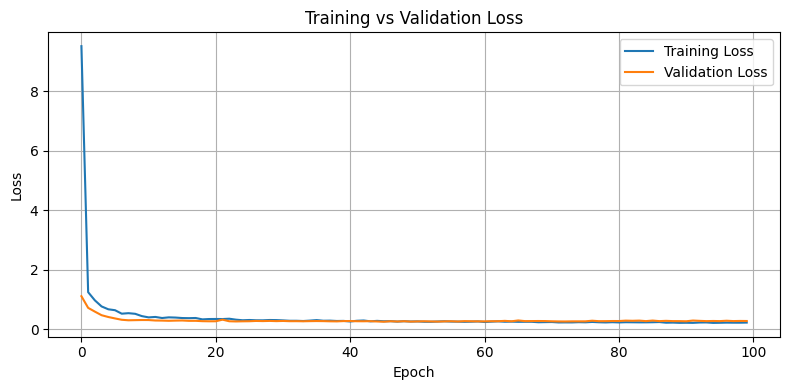


📊 Evaluation for aspect: 'driver' using TCN
  MSE  : 0.0470
  RMSE : 0.2168
  MAE  : 0.1827
  R²   : 0.6834

📈 Running TCN forecast for aspect: 'uber'
Epoch 1/100


<ipython-input-3-d57d51fa901d>:30: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at']).dt.date


213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - loss: 6.1252 - val_loss: 0.3212
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5115 - val_loss: 0.2904
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4312 - val_loss: 0.3513
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3868 - val_loss: 0.2740
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3596 - val_loss: 0.3274
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3365 - val_loss: 0.3381
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3245 - val_loss: 0.2647
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3419 - val_loss: 0.2605
Epoch 9/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3372 - val_loss: 0.2778
Epoch 10/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3080 - val_loss: 0.2851
Epoch 11/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2990 - val_loss: 0.2684
Epoch 12/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

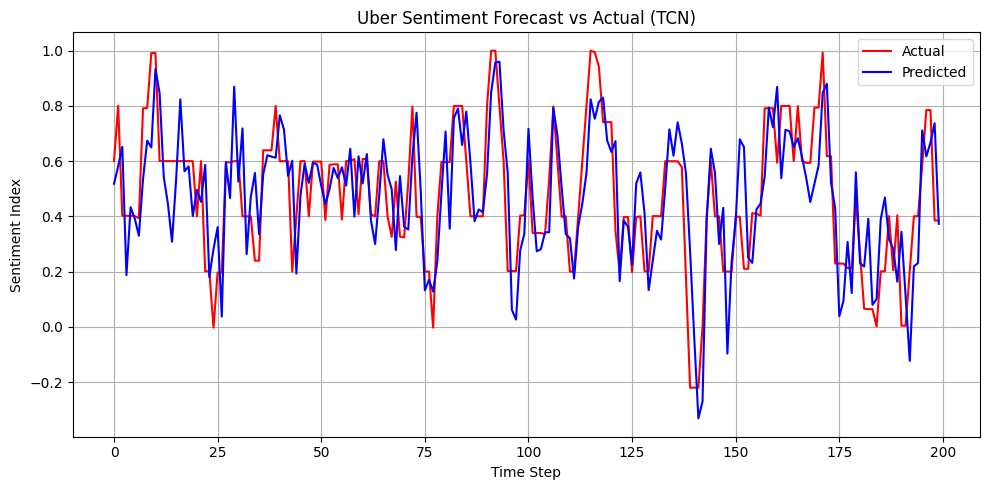

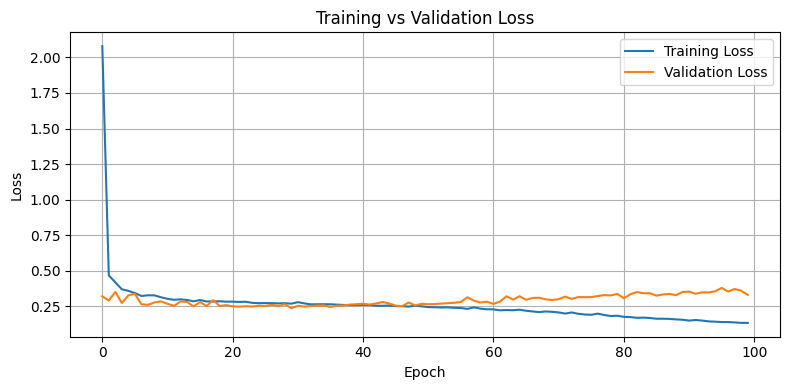


📊 Evaluation for aspect: 'uber' using TCN
  MSE  : 0.0286
  RMSE : 0.1691
  MAE  : 0.1360
  R²   : 0.5157

📈 Running TCN forecast for aspect: 'service'
Epoch 1/100


<ipython-input-3-d57d51fa901d>:30: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at']).dt.date


30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 335ms/step - loss: 21.7605 - val_loss: 1.0267
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.3536 - val_loss: 0.8754
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9627 - val_loss: 0.6693
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9278 - val_loss: 0.5206
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7670 - val_loss: 0.4278
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6271 - val_loss: 0.3720
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6340 - val_loss: 0.3722
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5500 - val_loss: 0.3448
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4922 - val_loss: 0.3167
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4711 - val_loss: 0.2771
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4308 - val_loss: 0.3003
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4167

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


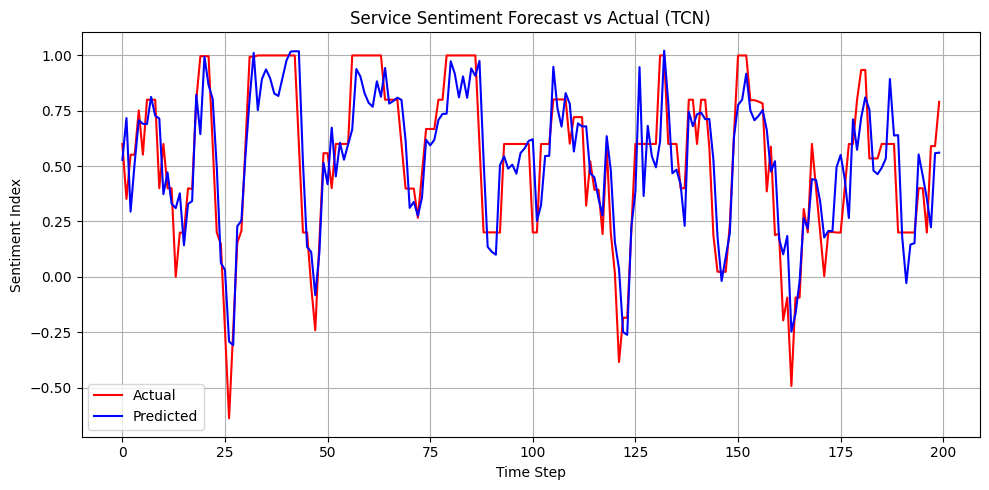

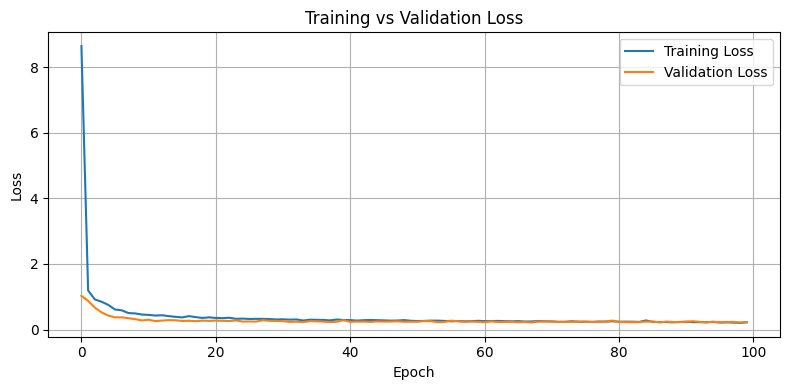


📊 Evaluation for aspect: 'service' using TCN
  MSE  : 0.0297
  RMSE : 0.1722
  MAE  : 0.1336
  R²   : 0.7576

📈 Running TCN forecast for aspect: 'app'
Epoch 1/100


<ipython-input-3-d57d51fa901d>:30: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at']).dt.date


34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 279ms/step - loss: 15.6603 - val_loss: 0.8208
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.4946 - val_loss: 0.5552
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0898 - val_loss: 0.4794
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8977 - val_loss: 0.3875
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7422 - val_loss: 0.4305
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7153 - val_loss: 0.3610
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6343 - val_loss: 0.3801
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5893 - val_loss: 0.3509
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5940 - val_loss: 0.4237
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6017 - val_loss: 0.3432
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4966 - val_loss: 0.3325
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4417 - 

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


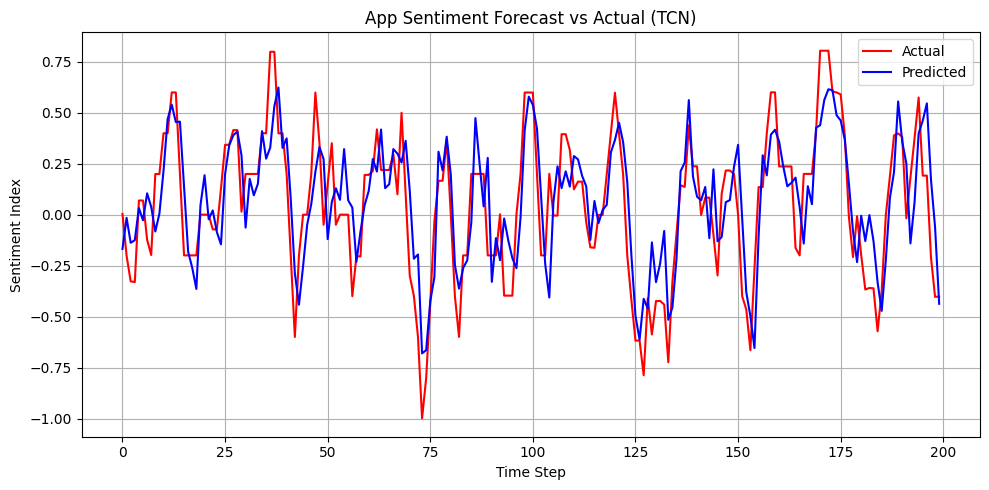

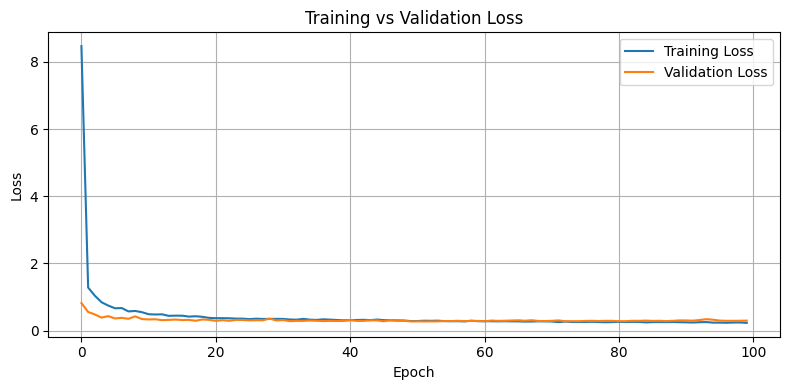


📊 Evaluation for aspect: 'app' using TCN
  MSE  : 0.0447
  RMSE : 0.2113
  MAE  : 0.1762
  R²   : 0.6333


In [5]:
aspects_to_evaluate = ["driver", "uber", "service", "app"]
results = {}

for aspect in aspects_to_evaluate:
    print(f"\n📈 Running TCN forecast for aspect: '{aspect}'")
    results[aspect] = forecast_sentiment_with_tcn(df.copy(), aspect, epochs=100)

In [6]:
tcn_results_df = pd.DataFrame(results).T
print("\n📊 Final Evaluation Results:")
display(tcn_results_df)


📊 Final Evaluation Results:


,MSE,RMSE,MAE,R²
driver,0.046997,0.216788,0.182748,0.683383
uber,0.028598,0.169109,0.135961,0.515737
service,0.029653,0.172200,0.133565,0.757622
app,0.044665,0.211340,0.176179,0.633292
